In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09.ipynb")

# Lab 9: Unconfoundedness

Welcome to the 9th DS102 lab! 

In this lab, you will explore the challenges of doing causal inference without randomization using the unconfoundedness assumption. We will help you reproduce results from a real labor economics application in a very famous paper by Robert Lalonde. Hopefully this will give you a taste of the issues that come up in practice. 

The code you need to write is indicated by `...`

## Collaboration Policy
You can submit the lab in pairs (groups of two, no more than two). **If you choose to work in a pair, please make sure to add your group member on Gradescope for both written and code submission.**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually and do not share your code with anyone other than your partner**. If you do discuss the assignments with people other than your partner please **include their names** in the cell below.

`<Collaborator Name> <Collaborator e-mail>`

## Submission
**For full credit, this assignment should be completed and submitted before Wednesday, Apr 2nd, 2025 at 05:00 PM PST.**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import itertools


import hashlib
def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

# Causal Inference Background and Review

## Potential Outcomes and Average Treatment Effect

In general, we can measure the causal effect of a binary treatment $Z$ on an outcome $Y$ by considering the potential outcomes $Y(0)$ and $Y(1)$. Recall that these are *potential* outcomes: they represent thought experiments about what would happen if the treatment was or wasn't applied. In the real world, we only ever get to observe one of them for any individual, depending on whether that unit received the treatment or not.

We defined the average treatment effect (ATE), represented by the Greek letter tau ($\tau$), as:

$$
\tau = E[Y(1) - Y(0)]
$$

This represents the causal effect of a treatment $Z$ on an outcome $Y$. We saw that in general, we were unable to estimate this without making assumptions. In the special case where our data come from a randomized experiment, then we saw that the Simple Difference in Observed group means (SDO) was an unbiased estimate of the ATE:

$$
\hat{\tau} = \underbrace{\frac{1}{n_1}\sum_{i: Z_i = 1} Y_i}_{\text{mean of treatment group}} -  \underbrace{\frac{1}{n_0}\sum_{i: Z_i = 0} Y_i}_{\text{mean of control group}}
$$

## Independence and Unconfoundedness
Recall that in a randomized experiment, we make treatment decisions completely at random. This prevents the treatment from being confounded by any external factors - if it was assigned completely at random then treatment cannot be correlated with unobserved variables. Unfortunately, in an observational study, we often must deal with confounders: variables that are correlated with both the treatment and the outcome. Mathematically, in a randomized experiment, we say that

$$
Z_i \perp\!\!\!\perp \big(Y_i(0), Y_i(1)\big)\,\, \forall i
$$

meaning that knowing any unit's treatment status doesn't give us any additional information about the distribution of their potential outcomes ("what-ifs"). For example, in a drug trial, because of randomization, the people who receive the drug have the same (distribution of) potential outcomes as the people who receive a placebo, since there are no systematic differences between the treatment and control groups.

In an observational study, this usually isn't true. For example, suppose we are interested in the effect of a job training program on income. People who receive the job training program might be poorer than people who don't, and so whether they receive the training or not, their incomes might be lower. Therefore, the confounding effect of socioeconomic status will cause the simple difference in means to be biased. If we observe socioeconomic status, then we can use various strategies to correct for it to recover the true causal effect of job training programs. 

This idea, that we observe all confounding varaibles so we can correct for them, is called **unconfoundedness**. Stated mathematically, the treatment and potential outcomes are *conditionally* independent given a set of known confounding variables $X$:

$$
Z_i \perp\!\!\!\perp \big(Y_i(0), Y_i(1)\big) \mid X_i \,\, \forall i
$$

If we make this assumption, we can use a few different approaches to estimate the average treatment effect. 

**Note:** work on causal inference has happened across many different fields - medicine, economics, education, psychology, etc. Unfortunately, in different fields, the unconfoundedness assumption goes by many different names. Some other popular names for unconfoundedness include: "exogeneity" (economics), "selection on observables" (statistics), and "ignorability" (medicine).

# Problem Setup and Data

For this lab, you'll be working with data from a job training program in the mid-1970s called the National Supported Work Demonstration. The data (and the results we'll reproduce) come from two famous papers. The first is a 1986 paper by Robert LaLonde, [Evaluating the Econometric Evaluations of Training Programs](https://business.baylor.edu/scott_cunningham/teaching/lalonde-1986.pdf). The second is a follow-up paper by Rajeev Dehejia and Sadek Wahba, [Propensity Score Matching Methods for Non-experimental Causal Studies](https://www.nber.org/papers/w6829), which as you can probably guess, applied propensity score methods. 

Here's a description of the NSW program from the original LaLonde paper (emphasis added):

> The National Supported Work Demonstration (NSW) was a temporary employment program designed to help disadvantaged workers lacking basic job skills move into the labor market by giving them work experience and counseling in a sheltered environment. Unlike other federally sponsored employment and training programs, the NSW program **assigned qualified applicants to training positions randomly**. Those assigned to the treatment group received all the benefits of the NSW program, while those assigned to the control group were left to fend for themselves.

Here are a few more important excerpts from the paper, describing the participants and data collected (links added):

> The MDRC admitted into the program [AFDC women](https://en.wikipedia.org/wiki/Aid_to_Families_with_Dependent_Children), ex-drug addicts, ex-criminal offenders, and high school dropouts of both sexes. For those assigned to the treatment group, the program guaranteed a job for 9 to 18 months, depending on the target group and site. The treatment group was divided into crews of three to five participants who worked together and met frequently with an NSW counselor to discuss grievances and performance...

> The type of work even varied within sites. In particular, male and female participants frequently performed different sorts of work. The female participants usually worked in service occupations, whereas the male participants tended to work in construction occupations.

> The MDRC collected earnings and demographic information from both the treatment and the control group at baseline and every nine months thereafter. MDRC also conducted up to four post-baseline interviews.

Our goal will be to estimate the causal effect of the training program on income. Specifically, we will compare the income of people in 1974, 1975 (before the training program) with their income in 1978 (after the program).

Just like LaLonde did, we'll start by evaluating the randomized experiment. Then, we'll look at what would happen if we didn't have a control group, and instead had to use data from an observational study.

# Part I: Randomized Experiment

Let's begin by looking at the data from the NSW experiment. We provide you with a subset of the original data studied in the Dehejia & Wahba paper, which is commonly used as a benchmark in causal inference. Note that this subset **only includes male participants and only those participants whose income in both 1974 and 1975 are observed** which will simplify the analysis.

It contains the following columns:
* `data_id`: always `NSW`, indicating that the data are from the NSW randomized experiment
* `treat`: binary variable indicating treatment (1 for job training, 0 for control)
* `age`: age in years
* `educ`: number of years of education
* `black`: whether the worker was Black (1) or not (0).
* `hisp`: whether the worker was Hispanic (1) or not (0).
* `marr`: whether the worker was married (1) or not (0).
* `nodegree`: whether the worker had a high school diploma (0) or not (1).
* `re74`, `re75`: earnings in 1974 and 1975, before the program
* `re78`: earnings in 1978, after the program.
* `outcome`: difference in earnings from 1974 to 1978

In [4]:
nsw = pd.read_csv('nsw_dw.csv')
nsw

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,outcome
0,NSW,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000,0.00,9930.0460,9930.0460
1,NSW,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000,0.00,3595.8940,3595.8940
2,NSW,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000,0.00,24909.4500,24909.4500
3,NSW,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000,0.00,7506.1460,7506.1460
4,NSW,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000,0.00,289.7899,289.7899
...,...,...,...,...,...,...,...,...,...,...,...,...
440,NSW,0.0,21.0,9.0,1.0,0.0,0.0,1.0,31886.430,12357.22,0.0000,-31886.4300
441,NSW,0.0,28.0,11.0,1.0,0.0,0.0,1.0,17491.450,13371.25,0.0000,-17491.4500
442,NSW,0.0,29.0,9.0,0.0,1.0,0.0,1.0,9594.308,16341.16,16900.3000,7305.9930
443,NSW,0.0,25.0,9.0,1.0,0.0,1.0,1.0,24731.620,16946.63,7343.9640,-17387.6560


In Part I, we leverage the fact that the participants were randomly assigned to the treatment group, i.e attending the training program (`treat = 1`) and the control group, i.e. not attending the training program (`treat = 0`). Hence, we can compute the causal effect using the following expression:

$$
\hat{\tau} = \underbrace{\frac{1}{n_1}\sum_{i: Z_i = 1} Y_i}_{\text{mean of treatment group}} -  \underbrace{\frac{1}{n_0}\sum_{i: Z_i = 0} Y_i}_{\text{mean of control group}}
$$

<!-- BEGIN QUESTION -->

## 1.a) Understanding causal inference assumptions

Even though the NSW program had male and female participants, our dataset only contains the men. Consider this paragraph from the original LaLonde paper:

> In particular, male and female participants frequently performed different sorts of work. The female participants usually worked in service occupations, whereas the male participants tended to work in construction occupations.

If we were to include the data from men and women and analyze them together, which assumption(s) would we be violating and why?

*Hint: remember that this is a randomized experiment.*

We would be violating SUTVA and unconfoundedness assumptions. Male and female both had different types of jobs so it was likely that their outcomes were different. Also gender is a cofounder that influences the treatment and outcomes, so we must condition on gender. 

<!-- END QUESTION -->

## 1.b)  Compute causal effect in randomized experiments

Complete the code below to output the causal effect of training program on participants' income using the expression above.

In [9]:
causal_effect_nsw = nsw[nsw["treat"] == 1]["outcome"].mean() - nsw[nsw["treat"] == 0]["outcome"].mean()
causal_effect_nsw

1805.7953458419956

In [10]:
grader.check("q1b")

q1b results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.c) Interpret the result
Based on your answer above, what is the causal effect of attending the training program on income? In other words, does attending the training program lead to higher income?

Those who attended the training program saw their income increase by $1805.79 on average compared to those who did not attend. 

<!-- END QUESTION -->

# Part II: Using an Observational Study

Often, we want to estimate the causal effect of a treatment without randomization. One issue is that because we can never observe the counterfactual potential outcomes ("the fundamental problem of causal inference"), in a typical observational study we can never check if our answer is correct. So then can we ever be sure that observational causal inference tools really work on real data? One of the reasons Lalonde's paper is so famous is because he had a brilliant idea about how to test observational methods. 

Since NSW was randomized, we know that we have an unbiased estimate of the true average treatment effect. Lalonde's idea was to replace the randomized control group with non-random observational data. Then one could apply causal inference methods to the true treated group and the observational control group like one would do in a normal observational study. But this time, **we know what the average treatment effect is supposed to be**, so we can check our answer afterward!

LaLonde used the Current Population Survey (CPS), a publicly available dataset, as a control group. Let's now look at this data: for your convenience, it has the same columns as the NSW data above. Note that it's much larger!

In [12]:
cps = pd.read_csv('cps.csv')
cps

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,outcome
0,CPS,0,45,11,0,0,1,1,21516.670,25243.550,25564.670,4048.0000
1,CPS,0,21,14,0,0,0,0,3175.971,5852.565,13496.080,10320.1090
2,CPS,0,38,12,0,0,1,0,23039.020,25130.760,25564.670,2525.6504
3,CPS,0,48,6,0,0,1,1,24994.370,25243.550,25564.670,570.3008
4,CPS,0,18,8,0,0,1,1,1669.295,10727.610,9860.869,8191.5740
...,...,...,...,...,...,...,...,...,...,...,...,...
15987,CPS,0,22,12,1,0,0,0,3975.352,6801.435,2757.438,-1217.9141
15988,CPS,0,20,12,1,0,1,0,1445.939,11832.240,6895.072,5449.1330
15989,CPS,0,37,12,0,0,0,0,1733.951,1559.371,4221.865,2487.9140
15990,CPS,0,47,9,0,0,1,1,16914.350,11384.660,13671.930,-3242.4200


For the rest of the lab, we'll work with a modified version of the data that doesn't have any randomized controls, only the ones from the general population. In the cell below, we creat a new dataframe called `obs` by concatenating the `cps` dataframe with rows of the `nsw` dataframe corresponding to the people who attended the training program.

**Your answers to all remaining questions should only use the `obs` table, not the `nsw` table!**

In [13]:
treated = nsw[nsw['treat'] == 1]
obs = pd.concat([treated, cps], ignore_index=True)
obs

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,outcome
0,NSW,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000,0.000,9930.0460,9930.0460
1,NSW,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000,0.000,3595.8940,3595.8940
2,NSW,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000,0.000,24909.4500,24909.4500
3,NSW,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000,0.000,7506.1460,7506.1460
4,NSW,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000,0.000,289.7899,289.7899
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,CPS,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352,6801.435,2757.4380,-1217.9141
16173,CPS,0.0,20.0,12.0,1.0,0.0,1.0,0.0,1445.939,11832.240,6895.0720,5449.1330
16174,CPS,0.0,37.0,12.0,0.0,0.0,0.0,0.0,1733.951,1559.371,4221.8650,2487.9140
16175,CPS,0.0,47.0,9.0,0.0,0.0,1.0,1.0,16914.350,11384.660,13671.9300,-3242.4200


The following histogram compares the distribution of education between the NSW treatment group and the CPS group:

<Axes: xlabel='educ', ylabel='Density'>

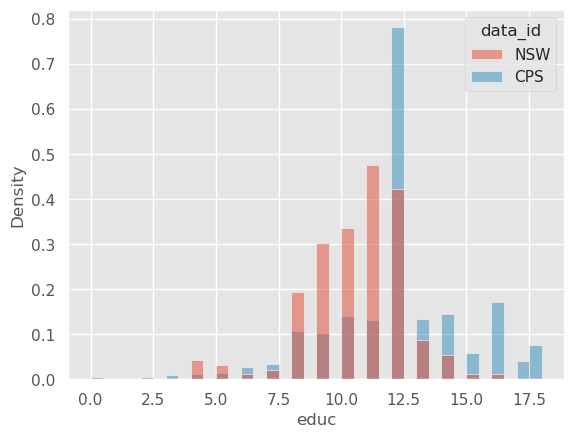

In [14]:
sns.histplot(data=obs, x='educ', hue='data_id', stat='density', binwidth=0.5, common_norm=False)

<!-- BEGIN QUESTION -->

## 2.a) Evaluating a possible confounder 

Based on the histogram above, we can say that education is a confounding variable. How can you justify this claim? In other words, why is education a confounding variable?

*Hint: What kind of association do you expect between education and income?*

Education is related to both treatment and outcome. The histogram shows  NSW having lower education levels compared to the CPS cohort. Also, people having higher educations means higher income. 

<!-- END QUESTION -->

## 2.b) Computing the SDO
As our first attempt to estimate the causal effect, we decide to try what we did in Question 1. In other words, we compute the Simple Difference in Observed group means (SDO) for this observational data. 

Complete the code below to output compute the SDO using dataset `obs`.

In [19]:
sdo = obs[obs["treat"] == 1]["outcome"].mean() - obs[obs["treat"] == 0]["outcome"].mean()
sdo

3423.7105339914738

In [20]:
grader.check("q2b")

q2b results: All test cases passed!

The result that you found should be roughly $1600 larger than that of the causal effect that we measured in the randomized experiment. This is because of confounding: even though the actual effect of the program on income is much smaller (as we saw from the randomized experiment), the treatment group and our CPS group are very different. In particular, individuals in the treatment group faced many disadvantages that cause their earnings to be lower initially, and also caused them to be more likely to end up in the treatment group. For example, the NSW sample has systemtically lower levels of education than the CPS sample as we saw in Question 2a. 

# Part III: Unconfoundedness Techniques
Now let's go ahead and implement the techniques we discussed in class that utilize unconfoundedness to estimate the treatment effect.

**REMINDER:** the unconfoundedness assumption means we observe all the relevant confounding variables (like years of education). I.e. there are no **unobserved** confounders.

**Note**: For those of you who are interested in reading more, the setting that we're discussing here is often called a **Difference-in-Differences (DID)** experimental approach. It simply describes the usage of causal inference techniques when the treatment effect we're trying to estimate is being represented as a difference (i.e between those who did and didn't go through the program) in differences (i.e how income changed for each individual between 1978 and income in 1974).

## Technique 1. Outcome Regression
We know that education is a confounder. If we knew that education were the **only** confounder, then by unconfoundedness, we could fit a linear model of the following form:

$\text{Earnings} = \tau * Z + b*\text{years of education}$

We saw in lecture that if we make two assumptions, then the estimated coefficient of treament from OLS, $\hat{\tau}$, will be an unbiased estimate of the ATE. The two assumptions are:

1. Assume unconfoundedness given education.
2. Assume this linear model correctly describes the interaction between the variables.

Let's try it and see how well it performs. The code below are taken from previous labs. 

In [21]:
# No TODOs here: Just examine the code
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2)

As a reminder, in previous labs, we used it like this: `fit_OLS_model(student_data, 'NumBooks', ['ReadathonDuration', 'Income'])`

## 3.a) Fitting our model (single confounder)

Complete the code below by using the functions above to fit the linear model described above to predict the difference in earnings from 1974 to 1978 (i.e the `outcome` column) from the treatment and the education variable.

In [23]:
linear_model = fit_OLS_model(obs, "outcome",  ['treat', 'educ'])
print(linear_model.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                outcome   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              122.7
Date:                Sat, 29 Mar 2025   Prob (F-statistic):                    1.24e-53
Time:                        20:10:20   Log-Likelihood:                     -1.6866e+05
No. Observations:               16177   AIC:                                  3.373e+05
Df Residuals:                   16175   BIC:                                  3.373e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 3.b) Evaluating our model (single confounder)

Was our estimate of the treatment effect right or wrong? Roughly how far off were we from the truth? Can you think of a simple reason why the answer is so wrong?

Our estimate was wrong, since we initially had around 1800 in treatment effect while here we are seeing a coefficient of 3499.06. One reason could be is that we have more than 1 cofounders so our estimates are biased. There are omitted variables that if controlled for, will change the outcome. 

<!-- END QUESTION -->

## Adding More Controls
Now, suppose the full set of variables (age, years of education, Black/Hispanic race, marriage, and diploma) are the only confounders in this problem. In that case, we can make the unconfoundedness assumption, where $X$ represents the collection of all 6 confounding variables listed above. **We will make this assumption for the rest of the lab.**

Suppose we fit a linear model of the following form:

$\text{Earnings} = \tau * Z + a*\text{age} + b*\text{years of education} + c*\text{isBlack} + d*\text{isHispanic} + e*\text{isMarried} + f*\text{hasDiploma}$

Again, under the following assumptions, the estimated coefficient of treament from OLS, $\hat{\tau}$, will be an unbiased estimate of the ATE:

1. Assume unconfoundedness given this set of 6 variables.
2. Assume this new linear model correctly describes the interaction between the variables.

## 3.c) Fitting our model (multiple confounders)

Complete the code below by using the functions above to fit the linear model described above to predict the difference in earnings from 1974 to 1978 (i.e the `outcome` column) from the treatment and the 6 confounding variables.

In [25]:
full_linear_model = fit_OLS_model(obs, "outcome", ['treat', 'age', 'educ', 'black', 'hisp', 'marr', 'nodegree'])
print(full_linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                outcome   R-squared (uncentered):                   0.099
Model:                            OLS   Adj. R-squared (uncentered):              0.098
Method:                 Least Squares   F-statistic:                              253.0
Date:                Sat, 29 Mar 2025   Prob (F-statistic):                        0.00
Time:                        20:13:56   Log-Likelihood:                     -1.6795e+05
No. Observations:               16177   AIC:                                  3.359e+05
Df Residuals:                   16170   BIC:                                  3.360e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [26]:
grader.check("q3c")

q3c results: All test cases passed!

<!-- BEGIN QUESTION -->

## 3.d) Evaluating our model using only observational data information

Suppose we did not have access to the true causal effect that we computed in Part 1. Using what you've learned in Data 102, how could you compare the two models in parts 3.a) and 3.c)? According to your answer, which model is a better fit and why?

If we had no access to the true causal effect, we could see which outcomes had better metrics (mse , r squared, f-statistic). The second model has higher explained variance in the outcome variable by the predictors. The f-statistic is also higher which means the model with the full set of explanitory variables is a better result for us since it simply tells us that one of the predictors we have included is significantly associated witht the outcome.  

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 3.e) Evaluating our model (multiple confounders)

Now, let's use the fact that we know the true answer from Part 1. Was our estimate of the treatment effect from 3.c right or wrong? Is our answer better or worse than the answer from the simpler model in 3.a? Explain whether this is consistent with your answer from 3.c and why.

Our answer from 3c was closer to the true effect from the randomized experiment, where we had an outcome of around $1800. So adding more predictors got us closer to the true outcome.

<!-- END QUESTION -->

As mentioned, we'll take assumption 1 for granted for now. Assumption 2, however, is much more questionable: **it's not clear that our model correctly describes the interaction between the variables**. In particular, it assumes that the effect of each confounder is the same for both treatment and control, an assumption that is often violated.


For example, married individuals in the CPS sample might have more financial stability (since they may wait for financial stability to get married), which might not be true in the NSW sample (where individuals have much lower financial stability overall). But, the model above only uses one coefficient, $e$, for the effect of marriage on income, regardless of whether an individual is from the treatment or control.

For example, consider the following two histograms:

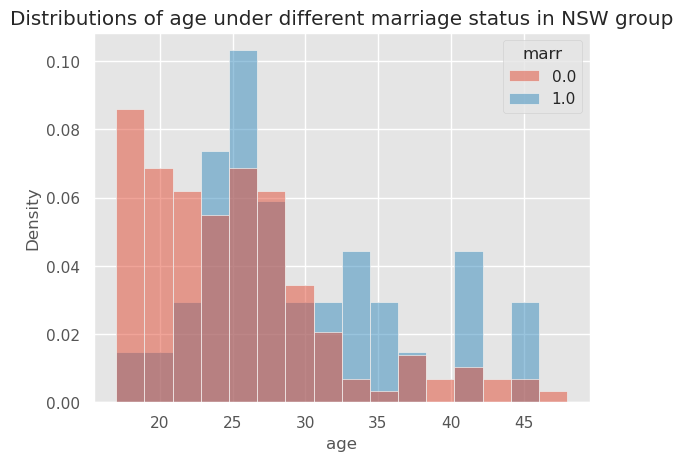

In [28]:
sns.histplot(data=obs[obs['data_id']=='NSW'], x='age', hue='marr', stat='density', common_norm=False, binwidth=2);
plt.title("Distributions of age under different marriage status in NSW group");

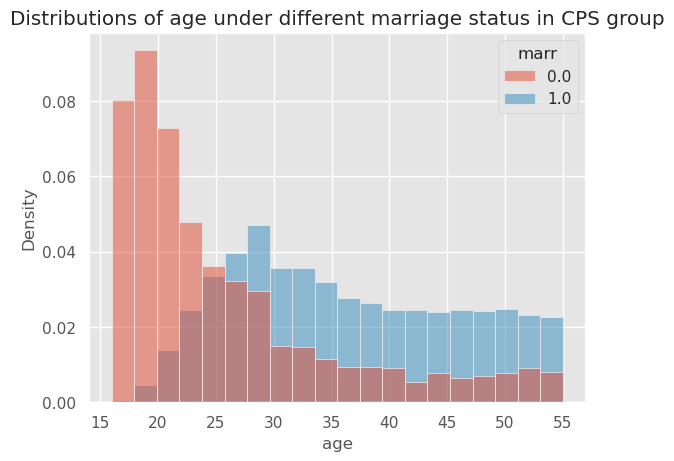

In [29]:
sns.histplot(data=obs[obs['data_id']=='CPS'], x='age', hue='marr', stat='density', common_norm=False, binwidth=2);
plt.title("Distributions of age under different marriage status in CPS group");

<!-- BEGIN QUESTION -->

## 3.f) Identifying model misspecification

Use the two histograms to argue why the simple linear model might be misspecified.

The linear model is likely misspecified because it assumes that the effect of being married is the same across ages / groups when we can see above in the histograms that the age distributions by marital status differ between both groups. This leaves us with biased estimates. 

<!-- END QUESTION -->

## Frequentist Perspectives on Causal Inference

Now, let's imagine that we had correctly specified our linear model, and that both assumption 1 and assumption 2 magically hold. Even then, there is still a chance that our estimated treatment effect $\hat{\tau}$ won't exactly line up with the true treatment effect! Why might this be the case?

To answer this question, consider the lens through which we are viewing causal inference: looking through this lab, you'll notice that our discussion centers around ***estimated*** treatment effects $\hat{\tau}$ that approximate some ***true, fixed, hidden*** average treatment effect $\tau$. This language should signal to you that we're utilizing a frequentist approach to causal inference.

If we're applying those same principles of frequentism here, the reason why our estimated treatment effect $\hat{\tau}$ won't always perfectly estimate the true treatment effect (despite meeting all our assumptions) is because of **randomness in the data**. Depending on the observational data that we have, we will calculate different estimates of the average treatment effect.

## 3.g) Bootstrapped estimates of the ATE

Continuing in this train of thought, one way to account for this uncertainty in our analysis is to create an interval that will, with 95% confidence, contain the true average treatment effect. To do this, we can employ a strategy that we explored earlier in the course: the bootstrap!

Fill in the skeleton code below to create a bootstrap algorithm. We'll use this function to compute the 95% confidence interval on the estimates of $\tau$.

*Hint: To pass the autograder, make sure you sample the data using `pandas` (see the [documentation here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)) and pass the `random_state` argument to the function call.*

In [33]:
#TODO: Fill in the missing values
def draw_tau_hat(data=obs, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
        for grading and troubleshooting purposes
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(frac =1, replace = True, random_state = random_state)
    fit_model = fit_OLS_model(sample, "outcome", ['treat', 'age', 'educ', 'black', 'hisp', 'marr', 'nodegree'])
    estimated_ate = fit_model.params['treat']
    return estimated_ate

def get_bootstrapped_ate(data=obs, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimates.append(draw_tau_hat(data, random_state = i))
    return estimates

In [34]:
grader.check("q3g")

q3g results: All test cases passed!

Now that we've defined a few functions, run the code below to calculate our confidence interval and visualize our sampling distribution.

In [35]:
# No TODOs here: just run the code!
ates = get_bootstrapped_ate(obs, 1000)
confidence_interval = [np.percentile(ates, 2.5), 
                       np.percentile(ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0])} to {np.round(confidence_interval[1])}")

Our 95% confidence interval ranges from 202.0 to 2862.0


Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE')

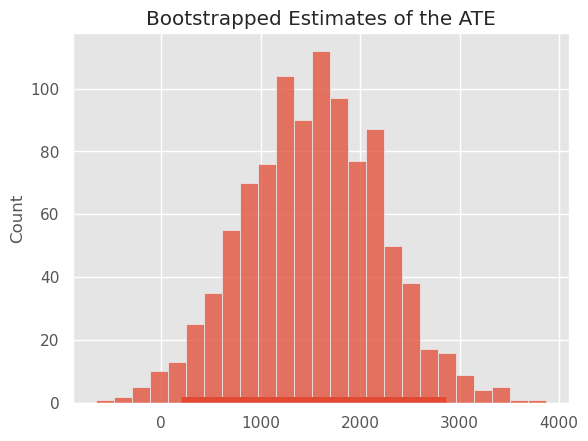

In [36]:
sns.histplot(ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE")

If you've defined your functions correctly, you should notice that our 95% confidence interval indeed captures our true ATE that we calculated at the start of the lab, and also does not include zero, making our result statistically significant!

## Technique 2: Matching

We have seen above that a simple linear regression model is not ideal - even if we add all of our variables as controls. Lalonde used these findings to argue that linear regression for causal inference is highly unreliable. Now, we consider a different technique introduced in lecture called matching. 

Consider two individuals, one treated and one untreated, with the exact same values of all confounding variables $X$. Here's an example of someone from the NSW study and someone from the CPS data with the exact same set of confounding variables:

In [37]:
nsw.iloc[50:51, :]

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,outcome
50,NSW,1.0,28.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
cps.iloc[2363:2364, :]

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,outcome
2363,CPS,0,28,8,1,0,0,1,15286.2,3863.516,0.0,-15286.2


If we assume unconfoundedness, then for these two people, there should be no other variables that have an effect on both the treatment and the outcome. So, by subtracting their outcomes, we should be able to estimate the causal effect of the job training program for this particular $X$ (specifically, 28-year old, unmarried, Black, non-Hispanic people without high school diplomas who've completed 8 years of schooling).

If we do this for every possible set of values for the confounders $X$, then we can take all of them and compute the expectation (weighting each by the probability of seeing that corresponding value of $X$). Empirically, this corresponds to just taking the average of all the data points.

Here is the matching algorithm in English:

1. For each treated row:

   * Find all untreated rows that have the exact same values of all confounders.
   * Take those untreated rows and average their outcome
   * Subtract the average above from the treated row's outcome


2. For each *untreated* row:
   * Find all *treated* rows that have the exact same values of all confounders.
   * Take those *treated* rows and average their outcome
   * Subtract the *untreated* row's outcome from the average above

3. Average all the results from steps 1 and 2.

<!-- BEGIN QUESTION -->

## 4.a) Challenges with exact matching
Explain why this exact maching algorithm will not work for the dataset provided. 

*Hint: There are six whole variables for every observation that we would need to find an exact match for.*

Exact matching here is a challenge because we have 6 cofounding variables. There are many combinations of values and it becomes unlikely to find individuals who have yet to be treated who are exact matches to another individual who is treated. 

<!-- END QUESTION -->

There are solutions such as approximate matching which matches people if they have similar features (not necessarily identical), but we'll instead turn to using propensity scores instead. Propensity scores are a dimensionality-reduction technique, that map all 6 confounders down to a single value per observation.

## Technique 3: Inverse Propensity Weighting
We've already seen that for this dataset, we can't use the simple difference in observed group means (SDO) to estimate the causal ATE. In this section, we'll try inverse propensity weighting instead. Recall the definition of the propensity score: it is the probability that a unit was treated, conditioned on a particular set of confounders $x$:

$$
e(x) = P(Z=1 | X=x)
$$

This is also sometimes called a "selection model" because it uses the covariates to model how observations are selected into treatment or control.  The simplest and most common way to compute propensity scores is using logistic regression: you'll get practice with this on HW4. In particular, in this example, we would use the `treat` column as our target variable and the confounders as our predictors.

In this lab, we have computed the propensity scores for you using a slightly more complex model that includes income before the program (`re74`) and flexibly models some nonlinear interactions. You'll get some practice with computing propensity scores on HW4.

In [39]:
# Import obs data with propensity scores computed
obs_prop = pd.read_csv('obs_with_propensity_scores.csv')
obs_prop.drop('Unnamed: 0', axis = 1, inplace = True)
obs_prop

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,outcome,pscore
0,NSW,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000,0.000,9930.0460,9930.0460,0.331238
1,NSW,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000,0.000,3595.8940,3595.8940,0.524712
2,NSW,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000,0.000,24909.4500,24909.4500,0.475520
3,NSW,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000,0.000,7506.1460,7506.1460,0.872560
4,NSW,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000,0.000,289.7899,289.7899,0.776362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16172,CPS,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352,6801.435,2757.4380,-1217.9141,0.097985
16173,CPS,0.0,20.0,12.0,1.0,0.0,1.0,0.0,1445.939,11832.240,6895.0720,5449.1330,0.003163
16174,CPS,0.0,37.0,12.0,0.0,0.0,0.0,0.0,1733.951,1559.371,4221.8650,2487.9140,0.002008
16175,CPS,0.0,47.0,9.0,0.0,0.0,1.0,1.0,16914.350,11384.660,13671.9300,-3242.4200,0.000177


Examine the following histogram of propensity scores, grouped by dataset:

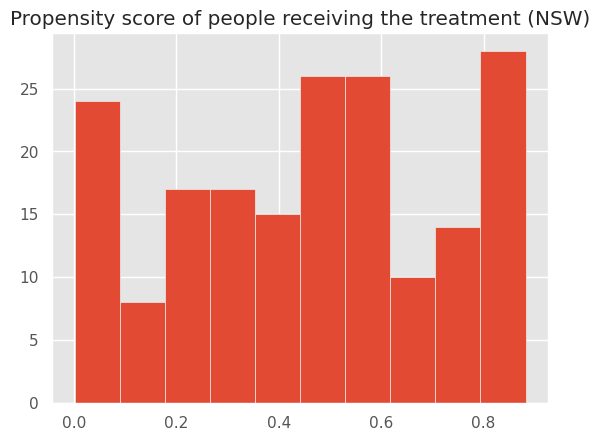

In [40]:
plt.hist(obs_prop[obs_prop['treat'] == 1]['pscore']);
plt.title("Propensity score of people receiving the treatment (NSW)");

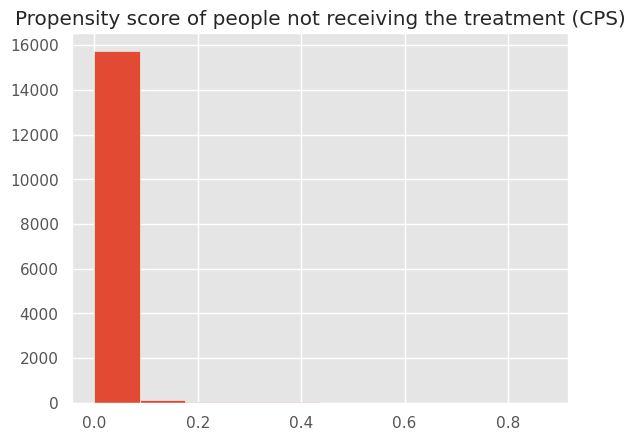

In [41]:
plt.hist(obs_prop[obs_prop['treat'] == 0]['pscore']);
plt.title("Propensity score of people not receiving the treatment (CPS)");

<!-- BEGIN QUESTION -->

## 5.a) Explain why the two histograms are so different

As you craft your response, be sure to consider the characteristics of the people participating in the training program (see Problem Setup and Data section).

This is perhaps because treated individuals may have no comparable controls with similar scores which leads to inflated weights.

<!-- END QUESTION -->

## 5.b) Inverse propensity weighting


We could use the propensity scores for a number of things, including matching, but in this lab we'll focus on inverse propensity weighting (IPW). Let $n = n_0 + n_1$ be the total number of observations. Recall from lecture that the IPW estimator of the ATE is:

$$
\hat{\tau}_{IPW} =
    \frac{1}{n}
    \underbrace{%
         \sum_{i: Z_i = 1} \frac{Y_i}{e(X_i)}
    }_{\text{reweighted treated rows}}
    -
    \frac{1}{n}
    \underbrace{%
        \sum_{i: Z_i = 0} \frac{Y_i}{1-e(X_i)}
    }_{\text{reweighted control rows}}
$$

Note that the weights are different for the two groups. Intuitively, the weights decrease the importance of points that have a high probability of being in the group that they're in.

For example, consider two individuals from the CPS data: person A, who looks very different from the treatment (NSW) population, and person B, who looks much more similar to the treatment (NSW) population. Person A's propensity score will be close to 0, so the denominator $1-e(X_A)$ will be close to 1, leaving the value roughly unchanged. Person B's propensity will be closer to 1, so the denominator will be small. This value will then be strongly upweighted. The idea is that we give more weight to control units who look like the treatment group and less weight to control units who don't so that we can make the two groups more comparable. 

Complete the cell below to compute the IPW estimate for the ATE.

In [45]:
n = len(obs_prop)
treated = obs_prop[obs_prop['treat'] == 1]
control = obs_prop[obs_prop['treat'] == 0]
treated_weighted = (treated['outcome'] / treated['pscore']).sum()
control_weighted = (control['outcome'] / (1 - control['pscore'])).sum()
ipw_estimate = (1 / n) * (treated_weighted - control_weighted)
ipw_estimate

-271.248370969481

In [46]:
grader.check("q5b")

q5b results: All test cases passed!

If you compare the estimate to the truth, you'll notice that **our answer doesn't even believe the effect of the program is positive!** This is a very important lesson: you have to be very careful when doing observational causal inference. Even with a sophistcated propensity score model, it is easy to go wrong. 

## 5.c) Trimming our propensities

Why was our result with IPW a negative number? This happens because if some observations are rare in the treatment group (i.e. $e(X) \approx 0$) then the inverse propensity score, $1/e(X)$ can be enormous. Our estimator gets swamped by variance. Recent work in IPW suggests that a good rule of thumb is to only include points with propensity scores between 0.1 and 0.9 which accepts some bias to reduce the variance.

In the cell below, remove any data points with propensity scores that are too low or too high, and repeat the computation in 3e.

In [49]:
trimmed = obs_prop[(obs_prop['pscore'] >= 0.1) & (obs_prop['pscore'] <= 0.9)]
treated_trim = trimmed[trimmed['treat'] == 1]
control_trim = trimmed[trimmed['treat'] == 0]
n_trimmed = len(trimmed)
treated_weighted = (treated_trim['outcome'] / treated_trim['pscore']).sum()
control_weighted = (control_trim['outcome'] / (1 - control_trim['pscore'])).sum()
trimmed_ipw_estimate = (1 / n_trimmed) * (treated_weighted - control_weighted)
trimmed_ipw_estimate

1529.686419782015

In [50]:
grader.check("q5c")

q5c results: All test cases passed!

This estimate is much closer to the true causal effect we obtained from the randomized experiment in part I, even if it is slightly too large. 

<!-- BEGIN QUESTION -->

## 5.d) Interpreting the result

Now let's interpret the result of IPW. Fill in the blanks below with the appropriate phrases:

*If we assume that ___, then the estimated effect of the program using IPW is that the program causes people to earn ___* *more than they would have.*

If we assume that all cofounders are observed and controlled for, then the estimated effect of the program using IPW is that the program causes people to earn 1529.68 more than they would have. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 5e

Give at least one reason why the IPW estimate doesn’t exactly match the true estimate, using what you know about the assumptons we’ve made. 

*Hint: there is more than one right answer.*

A reason could be the unconfoundedness assumption can not hold , so there are unobserved cofounders that affect both the predictor and outcomes. These are omitted variables that we can account for if we have the data and we can run 2 stage OLS to account and measure the omitted variable bias. 

<!-- END QUESTION -->

## Congratulations! You have finished Lab 9!

You've reached the end of the lab!

Before you submit to Gradescope, make sure you pass all the autograded portions of this lab. **Run the cell below to generate a PDF of your lab submission**, and **run the last cell to generate a zip file of your lab submission.** Do **not** create your lab PDF by exporting your notebook to a PDF.

To submit your lab to Gradescope, submit the PDF to Lab 9 Written and the zip file to Lab 9 Code.

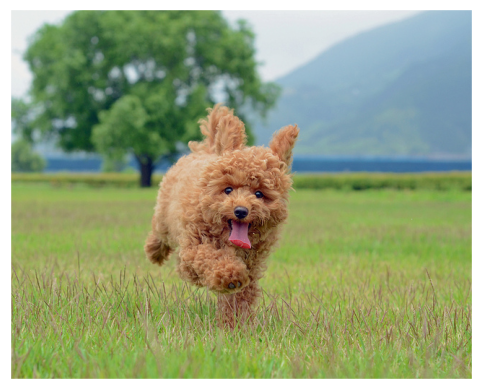

In [51]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab09.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab09.pdf')):
    img = mpimg.imread('qt.jpg')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()
    display(HTML("Download your PDF <a href='lab09.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [52]:
grader.check_all()

q1b results: All test cases passed!

q2b results: All test cases passed!

q3a results: All test cases passed!

q3c results: All test cases passed!

q3g results: All test cases passed!

q5b results: All test cases passed!

q5c results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [ ]:
grader.export(pdf=False, force_save=True)

<IPython.core.display.Javascript object>